In [267]:
import numpy as np
import pandas as pd
import sqlite3
import os

# Read all CSV files from datasets folder
datasets_path = 'datasets'

# Initialize empty dict to store dataframes
dfs = {}

# Loop through all files in directory
for filename in os.listdir(datasets_path):
    if filename.endswith('.csv'):
        # Create dataframe name from filename (remove .csv extension)
        df_name = filename.replace('.csv', '')
        print(df_name)
        
        # Read CSV file into dataframe
        file_path = os.path.join(datasets_path, filename)
        dfs[df_name] = pd.read_csv(file_path)

olist_sellers_dataset
olist_marketing_qualified_leads_dataset
product_category_name_translation
olist_orders_dataset
olist_order_items_dataset
olist_customers_dataset
olist_geolocation_dataset
olist_order_payments_dataset
olist_closed_deals_dataset
olist_order_reviews_dataset
olist_products_dataset


In [268]:
# import sqlalchemy and create a sqlite engine
import sqlalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

# export the dataframe as a table 'playstore' to the sqlite engine
dfs['olist_customers_dataset'].to_sql("olist_customers_dataset", con=engine)
dfs['olist_sellers_dataset'].to_sql("olist_sellers_dataset", con=engine)
dfs['olist_order_reviews_dataset'].to_sql("olist_order_reviews_dataset", con=engine)
dfs['olist_order_items_dataset'].to_sql("olist_order_items_dataset", con=engine)
dfs['olist_products_dataset'].to_sql("olist_products_dataset", con=engine)
dfs['olist_geolocation_dataset'].to_sql("olist_geolocation_dataset", con=engine)
dfs['product_category_name_translation'].to_sql("product_category_name_translation", con=engine)
dfs['olist_orders_dataset'].to_sql("olist_orders_dataset", con=engine)
dfs['olist_order_payments_dataset'].to_sql("olist_order_payments_dataset", con=engine)
dfs['olist_marketing_qualified_leads_dataset'].to_sql("olist_marketing_qualified_leads_dataset", con=engine)
dfs['olist_closed_deals_dataset'].to_sql("olist_closed_deals_dataset", con=engine)

842

In [269]:
# State to Region Allocation for Customer States
sql=''' 
SELECT *,
       CASE 
           WHEN customer_state IN ('SP', 'RJ', 'MG', 'ES') THEN 'Southeast'
           WHEN customer_state IN ('PR', 'SC', 'RS') THEN 'South'
           WHEN customer_state IN ('MT', 'MS', 'GO', 'DF') THEN 'Central-West'
           WHEN customer_state IN ('BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA') THEN 'Northeast'
           WHEN customer_state IN ('AM', 'PA', 'RO', 'AC', 'RR', 'TO', 'AP') THEN 'North'
           ELSE 'Unknown'
       END AS customer_region
FROM olist_customers_dataset;
''';

modified_customer_state = pd.read_sql_query(sql,con=engine)
modified_customer_state.to_csv('modified_olist_customers_dataset.csv', index=False)
modified_customer_state.to_sql("modified_olist_customers_dataset", con=engine)

99441

In [270]:
# State to Region Allocation for Seller States
sql=''' 
SELECT *,
       CASE 
           WHEN seller_state IN ('SP', 'RJ', 'MG', 'ES') THEN 'Southeast'
           WHEN seller_state IN ('PR', 'SC', 'RS') THEN 'South'
           WHEN seller_state IN ('MT', 'MS', 'GO', 'DF') THEN 'Central-West'
           WHEN seller_state IN ('BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA') THEN 'Northeast'
           WHEN seller_state IN ('AM', 'PA', 'RO', 'AC', 'RR', 'TO', 'AP') THEN 'North'
           ELSE 'Unknown'
       END AS seller_region
FROM olist_sellers_dataset;
''';

modified_seller_state = pd.read_sql_query(sql,con=engine)
modified_seller_state.to_csv('modified_olist_sellers_dataset.csv', index=False)

In [275]:
# RFM Analysis
## Recency is derived from the order_purchase_timestamp
## Frequency is derived from the number of orders per customer
## Monetary value is derived from the sum of the payment_value  
sql='''
select t2.customer_region, t2.customer_state,t1.customer_id, 
CAST(JULIANDAY('now') - JULIANDAY(MAX(t1.order_purchase_timestamp)) AS INTEGER) AS recency,
count(distinct t1.order_id) as frequency,
sum(payment_value) as monetary_value    
from olist_orders_dataset t1
join modified_olist_customers_dataset t2 on t1.customer_id = t2.customer_id
join olist_order_payments_dataset t3 on t1.order_id = t3.order_id
where t1.order_status = 'delivered'
group by t2.customer_region,t2.customer_state,t1.customer_id
''';

rfm_scores = pd.read_sql_query(sql,con=engine)

recency           0.431883
frequency         0.000000
monetary_value    9.366868
dtype: float64


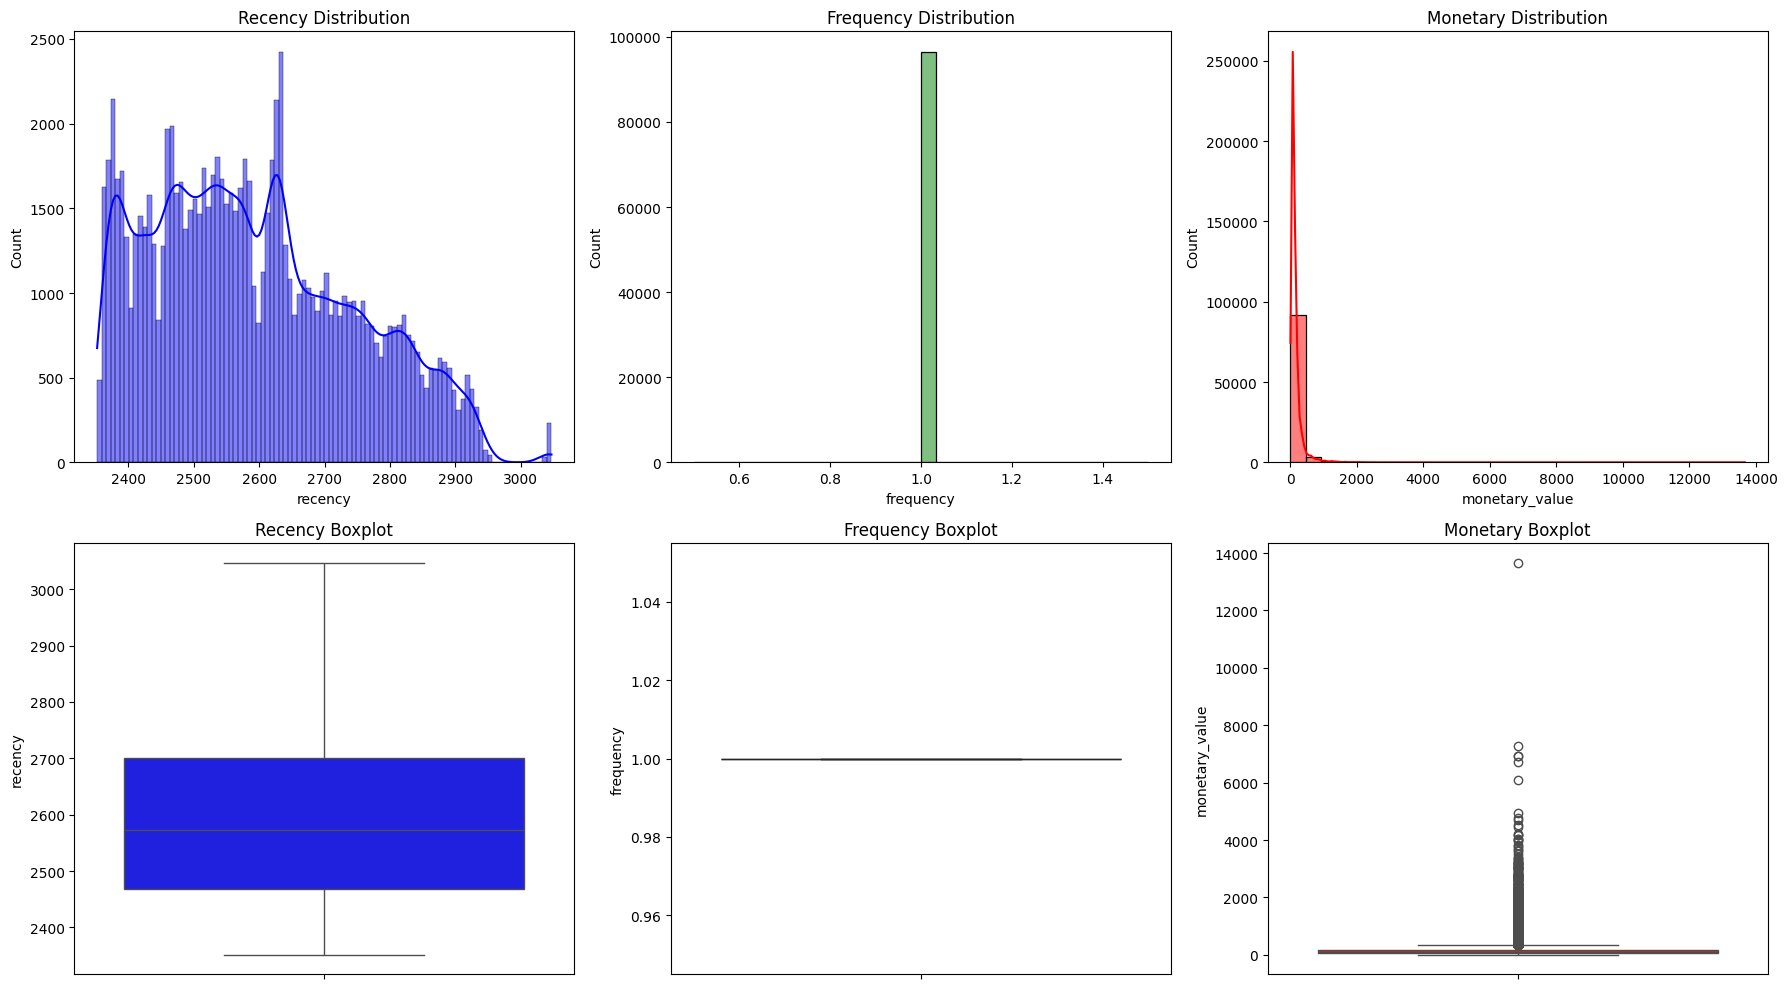

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

print(rfm_scores[['recency', 'frequency', 'monetary_value']].skew())
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(rfm_scores['recency'], bins=100, kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Recency Distribution")

sns.histplot(rfm_scores['frequency'], bins=30, kde=True, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Frequency Distribution")

sns.histplot(rfm_scores['monetary_value'], bins=30, kde=True, ax=axes[0, 2], color="red")
axes[0, 2].set_title("Monetary Distribution")

sns.boxplot(y=rfm_scores['recency'], ax=axes[1, 0], color="blue")
axes[1, 0].set_title("Recency Boxplot")

sns.boxplot(y=rfm_scores['frequency'], ax=axes[1, 1], color="green")
axes[1, 1].set_title("Frequency Boxplot")

sns.boxplot(y=rfm_scores['monetary_value'], ax=axes[1, 2], color="red")
axes[1, 2].set_title("Monetary Boxplot")

plt.tight_layout()

plt.show()


In [277]:
# transform skewed data
rfm_scores['log_monetary'] = np.log1p(rfm_scores['monetary_value'])  # log(1 + M)
print(rfm_scores[['recency', 'frequency', 'monetary_value','log_monetary']].skew())

def handle_rfm_score(rfm_scores):
    try:
        if rfm_scores['frequency'].nunique() == 1:
            # Assign F_score as 5 since all frequencies are the same
            rfm_scores['F_score'] = 5
        else:
            # Apply Quantile Binning for Frequency using pd.qcut when the frequency is variable
            rfm_scores['F_score'] = pd.qcut(rfm_scores['frequency'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

        # Apply Quantile Binning for Recency and Log Monetary
        rfm_scores['R_score'] = pd.qcut(rfm_scores['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')  # Lower recency is better
        rfm_scores['M_score'] = pd.qcut(rfm_scores['log_monetary'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')  # Higher monetary is better
        
        # Combine R_score, F_score, and M_score into one column 'RFM_score' as a string
        rfm_scores['RFM_score'] = rfm_scores['R_score'].astype(str) + rfm_scores['F_score'].astype(str) + rfm_scores['M_score'].astype(str)

        # Sort by RFM_score in descending order (since RFM_score is a string, sorting it numerically)
        rfm_scores = rfm_scores.sort_values(by='RFM_score', ascending=False)

        return rfm_scores

    except ValueError as ve:
        print(f"Error: {ve}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Example usage with your rfm_scores DataFrame
rfm_scores = handle_rfm_score(rfm_scores)

# If there was an error, rfm_scores will be None.
if rfm_scores is None:
    print("Error occurred while calculating RFM scores.")
else:
    print("RFM scores successfully calculated.")

rfm_scores.reset_index(drop=True).to_csv('rfm_scores.csv', index=False)


recency           0.431883
frequency         0.000000
monetary_value    9.366868
log_monetary      0.543897
dtype: float64
RFM scores successfully calculated.
